# Variational AutoEncoder with MNIST

### 데이터셋 로딩 및 준비

/home/zendo/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


device: cuda:0


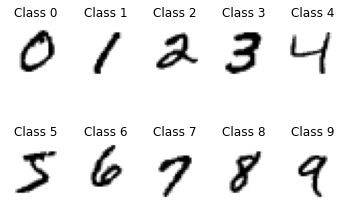

In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline

# define latent_dim(dim of z), batch_size
latent_dim = 2
batch_size = 64

# MNIST training data
train_set = dset.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)

# MNIST testing data
test_set = dset.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor())

# Create the dataloader
dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:",device)

# Plot some sample training images
for c in range(10):
    i = 0
    while True:
        if train_set.targets[i] == c:
            plt.subplot(2, 5, c+1)
            plt.axis('off')
            plt.imshow(train_set.data[i], cmap="gray_r")
            plt.title('Class %d' % c)
            break
        i += 1

## 모델 만들기

#### weight 초기화

In [2]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

### VAE 네트워크

In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            # input size. 1 x 28 x 28
            nn.Conv2d(1, 64, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(inplace=True),
            # state size. 64 x 14 x 14
            nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(inplace=True),
            # state size. 128 x 8 x 8
            nn.Conv2d(128, 256, 3, stride=2, padding=1, bias=False),
            nn.LeakyReLU(inplace=True),
            # output size. 256 x 4 x 4
            nn.Flatten(),
            nn.Linear(256*4*4, latent_dim*2, bias=False)
        )
        
        self.predecoder = nn.Linear(latent_dim, 100, bias=False)
        
        self.decoder = nn.Sequential(
            # input size. 100 x 1 x 1
            nn.ConvTranspose2d(100, 256, 4, stride=1, padding=0, bias=False),
            nn.LeakyReLU(inplace=True),
            # state size. 256 x 4 x 4
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, bias=False),
            nn.LeakyReLU(inplace=True),
            # state size. 128 x 7 x 7
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(inplace=True),
            # state size. 64 x 14 x 14
            nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1, bias=False),
            # No activation
            # output size. 1 x 28 x 28
        )
    
    def forward(self, input):
        mean, logvar = self.encode(input)
        z = self.reparameterize(mean, logvar)
        output = self.decode(z)
        return output, mean, logvar
    
    def encode(self, x):
        output = self.encoder(x)
        mean, logvar = torch.split(output, split_size_or_sections=2, dim=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = torch.randn_like(mean)
        return eps * torch.exp(logvar / 2) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.predecoder(z)
        logits = logits.view(-1, 100, 1, 1)
        logits = self.decoder(logits)
        if apply_sigmoid:
            probs = torch.sigmoid(logits)
            return probs
        else:
            return logits
    
    def sample(self, x):
        return self.decode(x, apply_sigmoid=True)

decoder를 이용한 이미지 생성.

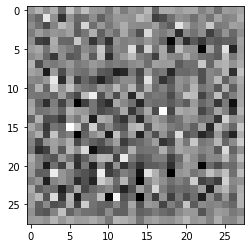

In [4]:
vae = VAE(latent_dim).to(device)
vae.apply(weights_init)

generated_image = vae.sample(torch.randn(latent_dim, device=device))
plt.imshow(generated_image[0,0,:,:].cpu().detach(), cmap='gray')

### 손실함수와 optimizer

#### 손실함수

$\text{loss} = \log p(x\vert z)+ \log p(z) - \log q(z\vert x)$

In [5]:
cross_entropy = nn.BCEWithLogitsLoss(reduction='sum')

def loss_function(output, x, mean, logvar):
    BCE = cross_entropy(output, x) # log p(x|z)
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp()) # log p(z) - log q(z|x)
    return BCE + KLD

#### optimizer

In [6]:
optimizer = optim.Adam(vae.parameters(), lr=1e-4)

## 훈련

In [7]:
num_epochs = 100
num_examples_to_generate = 16

img_list = []
losses = []
seed = torch.randn(num_examples_to_generate, latent_dim, device=device)
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # train with batch
        vae.zero_grad()
        images = data[0].to(device)
        # forward pass batch through vae
        output, mean, logvar = vae(images)
        # calculate gradient in backward pass
        loss = loss_function(output, images, mean, logvar)
        loss.backward()
        # update vae
        optimizer.step()
        
        if i == len(dataloader)-1:
            # pring training status
            print('[%3d/%d]\tloss: %.4f'
                  %(epoch+1, num_epochs ,loss.item()))
            # save losses for later plot
            losses.append(loss.item())
        
            # check how the generator is doing by saving generator's output on seed
            with torch.no_grad():
                generated_image = vae.sample(seed).detach().cpu()
            img_list.append(vutils.make_grid(generated_image, nrow=4, padding=2, normalize=True))


[  1/100]	loss: 5915.3472
[  2/100]	loss: 5859.0347
[  3/100]	loss: 5312.4614
[  4/100]	loss: 5770.8242
[  5/100]	loss: 5485.3994
[  6/100]	loss: 5946.1064
[  7/100]	loss: 5148.1313
[  8/100]	loss: 5222.7842
[  9/100]	loss: 4810.2397
[ 10/100]	loss: 5724.6240
[ 11/100]	loss: 4993.8042
[ 12/100]	loss: 5142.8340
[ 13/100]	loss: 5419.8213
[ 14/100]	loss: 5360.1221
[ 15/100]	loss: 5466.4946
[ 16/100]	loss: 5378.5234
[ 17/100]	loss: 4903.3740
[ 18/100]	loss: 5348.3721
[ 19/100]	loss: 4905.3896
[ 20/100]	loss: 5409.5361
[ 21/100]	loss: 5119.0693
[ 22/100]	loss: 4852.0415
[ 23/100]	loss: 4976.8921
[ 24/100]	loss: 5628.7515
[ 25/100]	loss: 4851.9834
[ 26/100]	loss: 4828.0488
[ 27/100]	loss: 5188.5068
[ 28/100]	loss: 4487.0229
[ 29/100]	loss: 4392.1289
[ 30/100]	loss: 5402.1621
[ 31/100]	loss: 4522.8784
[ 32/100]	loss: 4957.9990
[ 33/100]	loss: 4756.8501
[ 34/100]	loss: 4736.5786
[ 35/100]	loss: 4621.4312
[ 36/100]	loss: 4544.7573
[ 37/100]	loss: 5080.3452
[ 38/100]	loss: 4910.1543
[ 39/100]	lo

### 결과

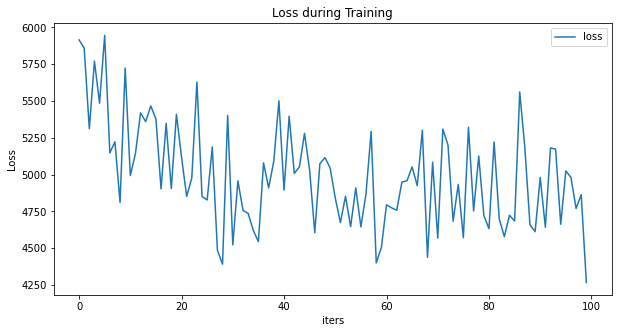

In [8]:
plt.figure(figsize=(10,5))
plt.title('Loss during Training')
plt.plot(losses, label='loss')
plt.xlabel("iters")
plt.ylabel("Loss")
plt.legend()
plt.show()

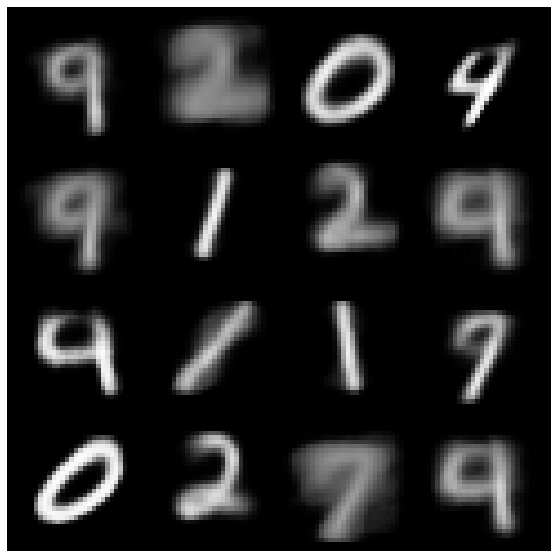

In [9]:
fig = plt.figure(figsize=(10,10))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=100)
HTML(ani.to_jshtml())

### Latent space

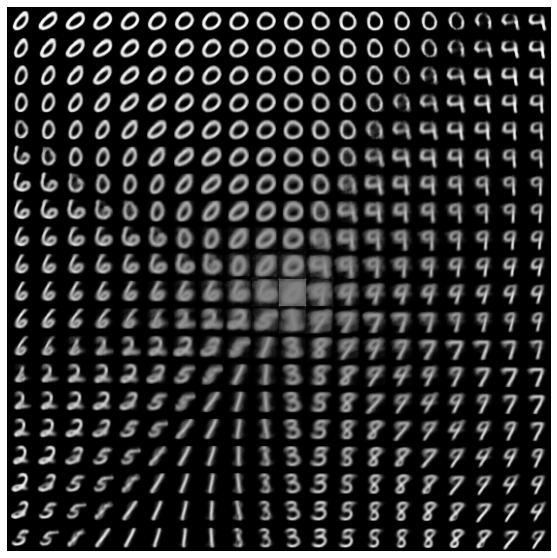

In [11]:
n = 20
norm = torch.normal(0, 1, size=(1000,))
cut = torch.arange(0.05,0.95,step = (0.95-0.05)/n)
grid_x = grid_y = torch.quantile(norm, cut)
image_width = image_height = 28 * n
image = np.zeros((image_height, image_width))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z = torch.FloatTensor([[xi, yi]]).to(device)
        x_decoded = vae.sample(z)
        digit = x_decoded.view(-1, 28, 28)
        image[i * 28:(i+1)*28, j*28:(j+1)*28] = digit.detach().cpu().numpy()

plt.figure(figsize=(10,10))
plt.imshow(image, cmap="gray")
plt.axis('off')
plt.show()